# Adding synthetic noise and test denoisers

In [1]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

## Create noisy references

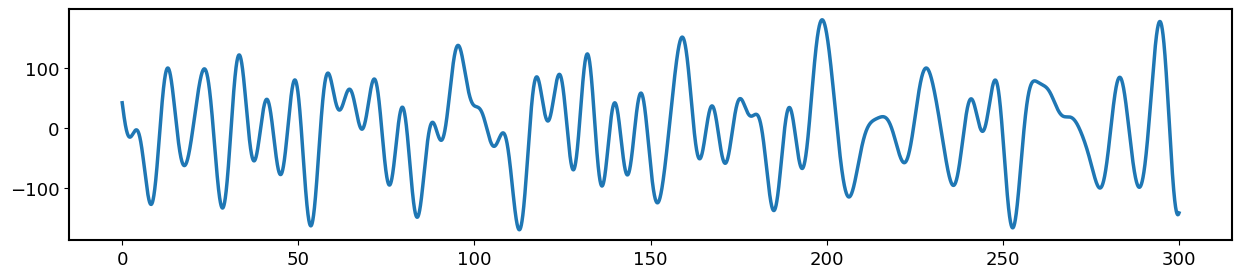

In [8]:
###############################
N = 30000
dt = 1e-2
pi = np.pi
nb_parts = 100
n_folds = 1
X_train = np.empty(shape=[2,N])
X_test = np.empty(shape=[n_folds,2,N])
###############################
phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
f = rnd.uniform(low=.02, high=.15, size=nb_parts)*dt
A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
###############################
time = np.arange(0,N,1)
t = np.arange(0,N*dt,dt)
pend1 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(0),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(60),0]), dt=dt)
###############################
x_train = 0
for i in range(nb_parts):
    x_train = x_train + A[i]*np.sin(2*pi*f[i]*time + phi[i])
    
x_train = x_train/max(max(x_train),-min(x_train))*pi
pend1.ref = x_train   
###############################
pend2.ref = np.empty(shape=[n_folds,N])
for j in range(n_folds):
    x_test = 0
    phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
    f = rnd.uniform(low=.02, high=.15, size=nb_parts)*dt
    A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
    for i in range(nb_parts):
        x_test = x_test + A[i]*np.sin(2*pi*f[i]*time + phi[i])
    x_test = x_test/max(max(x_test),-min(x_test))*pi
    pend2.ref[j,:] = x_test
###############################
fig, ax = plt.subplots(ncols=1, figsize=(15,3))
ax.plot(t,rad2deg(x_train))

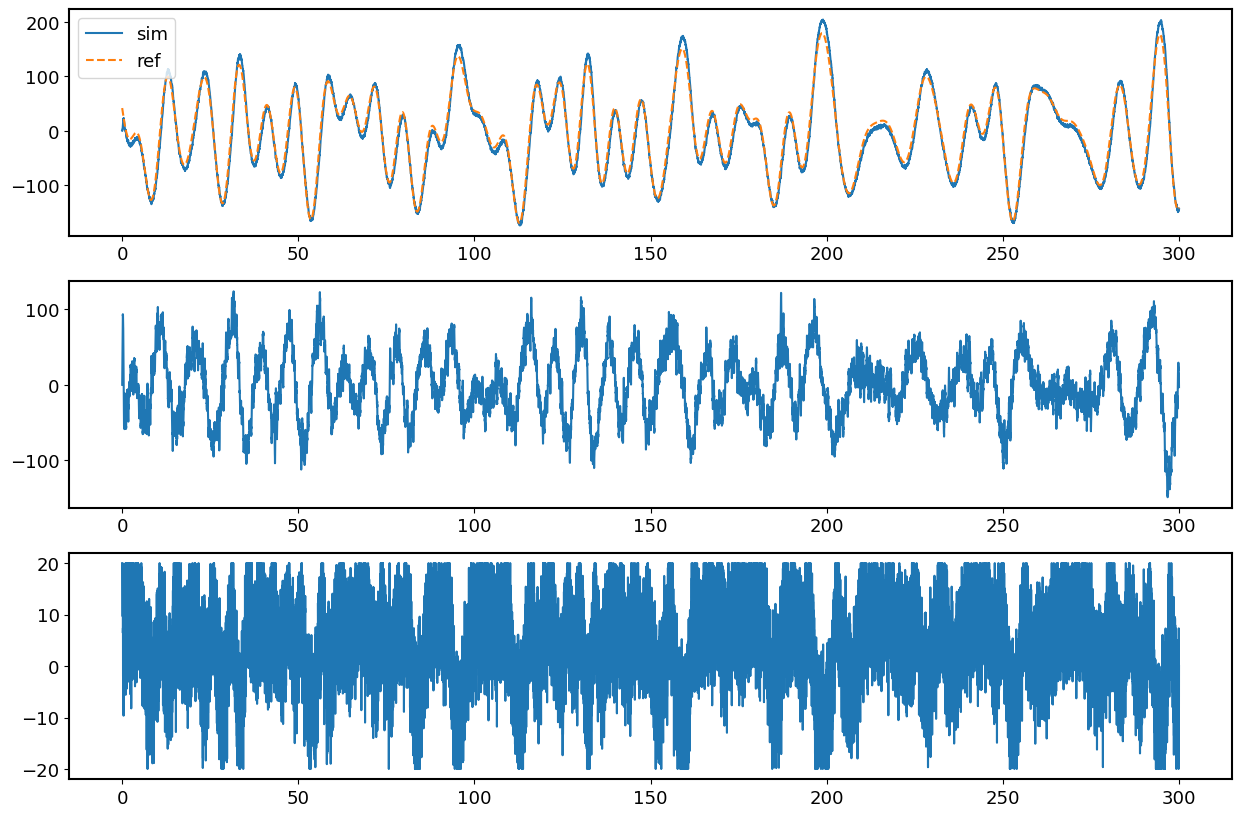

In [14]:
Kp, Ki, Kd = 50, 20, 5
pend1.U, pend2.U = np.zeros(shape=[N]), np.zeros(shape=[n_folds,N])
pend1.X, pend2.X = np.zeros(shape=[2,N]), np.zeros(shape=[n_folds,2,N])
# TRAINING ###################################
X_train[0,0] = x_train[0]
for i in range(N-1):
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], Kp, Kd, Ki, pend1.dt, 20, limit=[-20,20])[0] 
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step') + rnd.normal(0,.01,2)
# TESTING ####################################
for j in range(n_folds):
    pend2.X[j,0,0] = pend2.ref[j,0]
    for i in range(N-1):
        pend2.U[j,i] = PID(pend2.X[j,:,:], i, pend2.ref[j,i], Kp, Kd, Ki, pend2.dt, 20, limit=[-20,20])[0] 
        pend2.X[j,:,i+1] = RK4(pend2.dynamics, pend2.X[j,:,i], pend2.U[j,i], pend2.dt, type='controller-step-by-step') + rnd.normal(0,.01,2)
    
fig, ax = plt.subplots(nrows=3, figsize=(15,10))
plt.rcParams['lines.linewidth'] = 1.5
ax[0].plot(t,rad2deg(pend1.X[0,:]),label='sim'), ax[0].plot(t,rad2deg(pend1.ref),linestyle='dashed',label='ref'),ax[0].legend()
ax[1].plot(t,rad2deg(pend1.X[1,:]))
ax[2].plot(t,pend1.U)
plt.rcParams['lines.linewidth'] = 2.5

## Model training

In [16]:
# FIXED PARAMETERS #####################################
pend = pend1
Tau = np.array([7,9,10,12,14])
model1 = HAVOK(pend.X, pend.U)
# SWEEP THROUGH PARAMETERS #############################
Horizon = np.arange(20,120,10)
Delay_spacing = np.arange(10,np.int(.8*pend.N/max(Horizon)-1),10)
residuals = np.empty(shape=[len(Tau),2,len(Delay_spacing),len(Horizon)])
traj_error = np.empty(shape=[len(Tau),2,len(Delay_spacing),len(Horizon)])
for t in range(len(Tau)):
    for i in range(len(Horizon)):
        for j in range(len(Delay_spacing)):
            model1.HANKEL(Horizon[i], delay_spacing=Delay_spacing[j])
            model1.SVD(Tau[t])
            model1.LS(Tau[t],rcond=0)
            model1.Simulate(pend.X[:,0])
            model1.TrajError(pend.X)

            residuals[t,:,j,i] = model1.residuals
            traj_error[t,:,j,i] = model1.traj_error
            if (traj_error[t,0,j,i] >= .5e3) or (np.isnan(traj_error[t,0,j,i])): traj_error[t,0,j,i] = .5e3
            if (traj_error[t,1,j,i] >= .5e3) o r(np.isnan(traj_error[t,1,j,i])): traj_error[t,1,j,i] = .5e3

Min of trajectory error in position : ( 110 , 110 ) Value for pos. :  217.94105181884527 Value for vel. :  126.63178995709468 , delay =  7
Min of trajectory error in velocity : ( 90 , 100 ) Value for pos. :  266.5557192802764 Value for vel. :  125.14393202467416 , delay =  7
Min of trajectory error in position : ( 10 , 60 ) Value for pos. :  226.89088944127909 Value for vel. :  133.51282528958424 , delay =  9
Min of trajectory error in velocity : ( 130 , 110 ) Value for pos. :  247.1818704091074 Value for vel. :  128.07186778266012 , delay =  9
Min of trajectory error in position : ( 100 , 110 ) Value for pos. :  212.2043024871952 Value for vel. :  128.9535124424837 , delay =  10
Min of trajectory error in velocity : ( 70 , 110 ) Value for pos. :  271.41109221894675 Value for vel. :  128.8925265620843 , delay =  10
Min of trajectory error in position : ( 60 , 90 ) Value for pos. :  234.02291200404042 Value for vel. :  162.1344938231601 , delay =  12
Min of trajectory error in velocity 

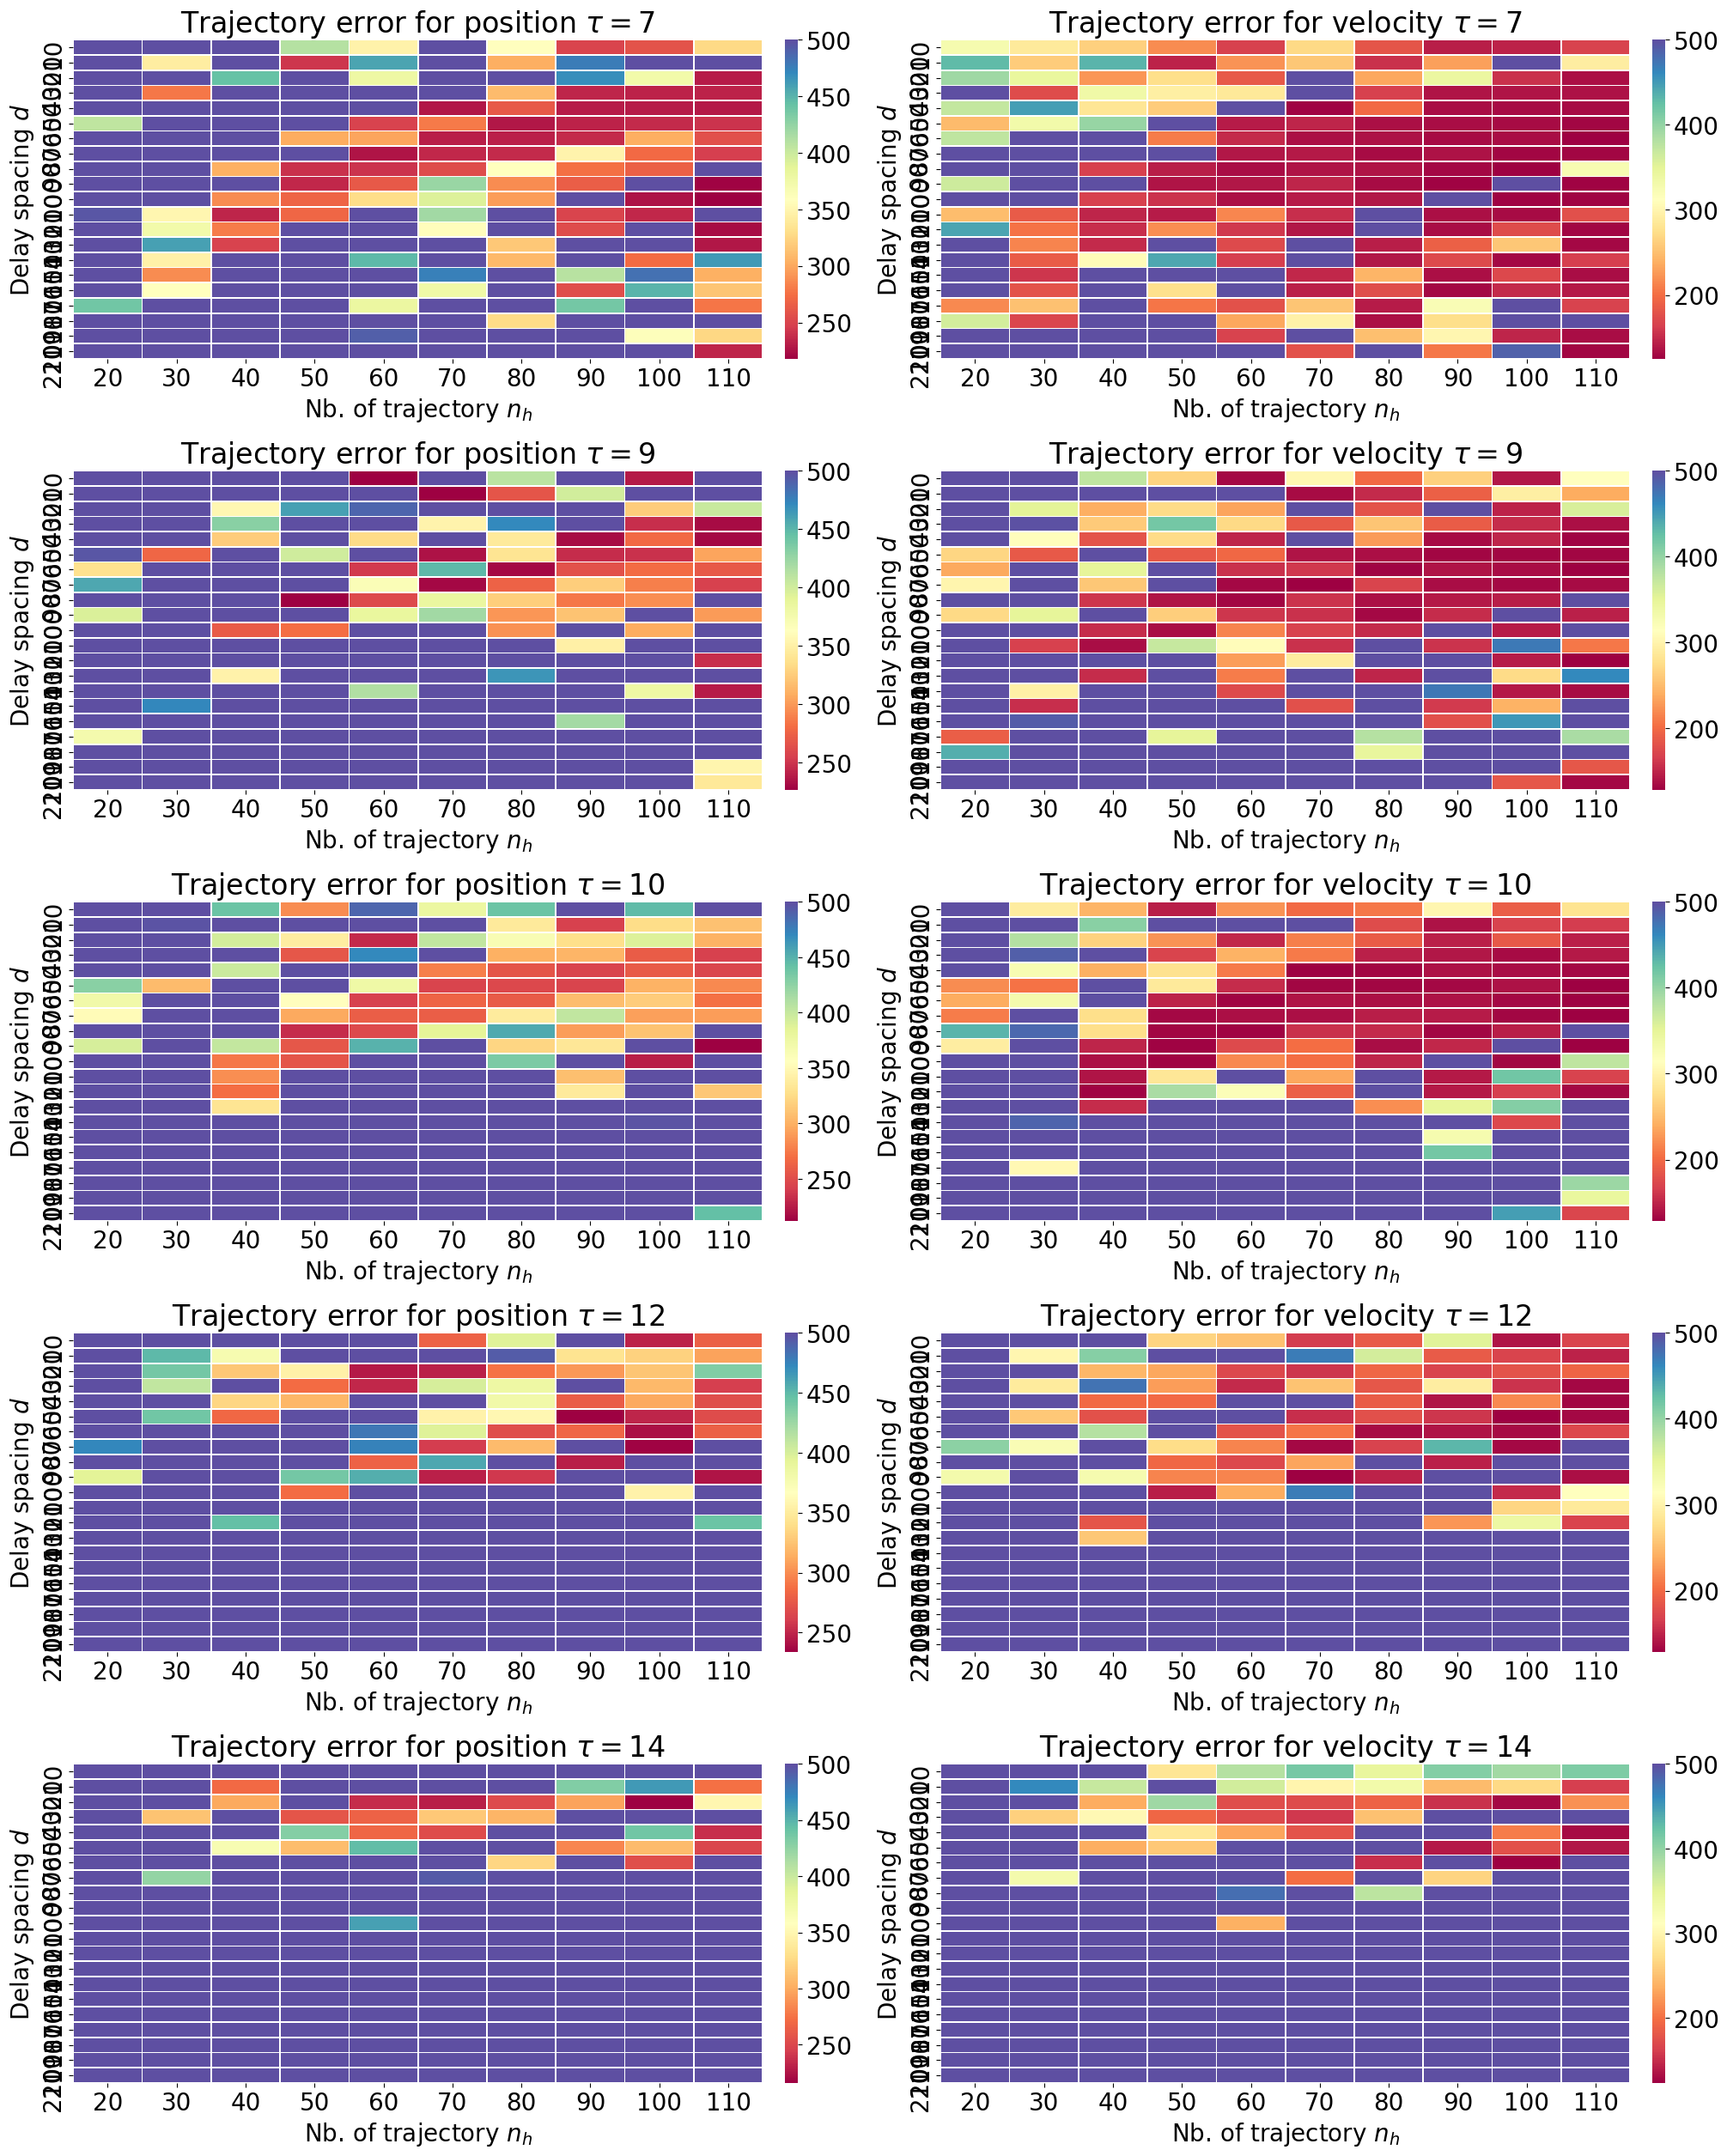

In [17]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(len(Tau),2, 
                       constrained_layout = True, figsize=(20,5*len(Tau)))

for t in range(len(Tau)):

    ax[t,0].set_title(r'Trajectory error for position $\tau = $'+str(Tau[t]))
    snb.heatmap(traj_error[t,0,:,:],cmap='Spectral',ax=ax[t,0],linewidths=.5)
    ax[t,0].set_xlabel(r'Nb. of trajectory $n_h$'), ax[t,0].set_ylabel(r'Delay spacing $d$')
    ax[t,0].set_xticks(np.arange(0.5,len(Horizon),1)), ax[t,0].set_yticks(np.arange(0.5,len(Delay_spacing),1))
    ax[t,0].set_xticklabels(Horizon), ax[t,0].set_yticklabels(Delay_spacing)

    ax[t,1].set_title(r'Trajectory error for velocity $\tau = $'+str(Tau[t]))
    snb.heatmap(traj_error[t,1,:,:],cmap='Spectral',ax=ax[t,1],linewidths=.5)
    ax[t,1].set_xlabel(r'Nb. of trajectory $n_h$'), ax[t,1].set_ylabel(r'Delay spacing $d$')
    ax[t,1].set_xticks(np.arange(0.5,len(Horizon),1)), ax[t,1].set_yticks(np.arange(0.5,len(Delay_spacing),1))
    ax[t,1].set_xticklabels(Horizon), ax[t,1].set_yticklabels(Delay_spacing)
    
    index = np.argmin(traj_error[t,0,:,:])
    pos_y, pos_x = index//len(Horizon), index%len(Horizon)
    print('Min of trajectory error in position : (',Delay_spacing[pos_y],',',Horizon[pos_x],')','Value for pos. : ',traj_error[t,0,pos_y,pos_x],
          'Value for vel. : ',traj_error[t,1,pos_y,pos_x],', delay = ',Tau[t])

    index = np.argmin(traj_error[t,1,:,:])
    pos_y, pos_x = index//len(Horizon), index%len(Horizon)
    print('Min of trajectory error in velocity : (',Delay_spacing[pos_y],',',Horizon[pos_x],')','Value for pos. : ',traj_error[t,0,pos_y,pos_x],
          'Value for vel. : ',traj_error[t,1,pos_y,pos_x],', delay = ',Tau[t])